In [1]:
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.xception import preprocess_input
from models import xception_feature_extractor, caption_model
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [2]:
# language_model = caption_model(max_len=50, vocab_size=10970, train=True)
# language_model.load_weights('models/top_weights_p.h5')
# language_model.save('50.h5')

In [3]:
# language_model = load_model('50.h5')
# feature_extractor = xception_feature_extractor()
# final_model = caption_model(max_len=50, vocab_size=10970, feature_extractor_model=feature_extractor)

In [4]:
# for layer in language_model.layers:
#     if layer.count_params():
#         weights = layer.get_weights()
#         xlayer = final_model.get_layer(layer.name)
#         xlayer.set_weights(weights)
# final_model.save('final_model.h5')

In [5]:
model = load_model('final_model.h5')

In [6]:
image_dir = 'images/val2014'
img_height, img_width = 299, 299

def get_image(path:str):
    image = load_img(path)
    image = img_to_array(image)
    return image

with open('wordtoidx.pkl', 'rb') as f:
    word_idx = pickle.load(f)
idx_word = {v:k for k,v in word_idx.items()}

def wordtoidx(word:str):
    idx = word_idx[word]
    return idx

def idxtoword(idx:int):
    if idx == 0:
        return '<unk>'
    word = idx_word[idx]
    return word

In [7]:
test_images = os.listdir(image_dir)
print(f'Found {len(test_images)} test images')

Found 40504 test images


In [8]:
def greedy_decoder(image):
    img = image.copy()
    img = cv2.resize(img, (299, 299))
    img = preprocess_input(img)
    inp ='startseq'
    while 'endseq' not in inp and len(inp.split())<50:
        encoded = [wordtoidx(word) for word in inp.split()]
        encoded = pad_sequences([encoded], 50, padding='post')
        next_word = np.argmax(model.predict([np.expand_dims(img, axis=0), encoded]))
        inp = inp + ' ' + idxtoword(next_word)
    if 'endseq' in inp:
        return inp[9:-7]
    return inp[9:]

def beam_search(image, k=7):
    img = image.copy()
    img = cv2.resize(img, (299, 299))
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    
    startseq = [wordtoidx('startseq')]
    beams =[[startseq, 0]]
    while (len(beams[0][0]) < 30):
        temp = []
        for beam in beams:
            partial_cap = beam[0]
            encoded = pad_sequences([partial_cap], 50, padding='post')
            predictions = model.predict([img, encoded])
            most_likely_words = np.argsort(predictions[0])
            most_likely_words = most_likely_words[-k:]
            
            for word in most_likely_words:
                prob = predictions[0][word]                
                curr_partial_caption = beam[0][:]
                curr_prob = beam[1]            
                new_prob = curr_prob + prob
                curr_partial_caption.append(word)
                temp.append([curr_partial_caption, new_prob])
        beams = temp
        beams = sorted(beams,key=lambda beam:beam[1])
        beams = beams[-k:]

    encoded_caption = beams[-1][0]
    caption = ''
    for idx in encoded_caption[1:]:
        if idxtoword(idx) == 'endseq':
            break
        else:
            caption = caption + ' ' + idxtoword(idx)
    return caption

In [9]:
test = random.sample(test_images, 5)

In [ ]:
for image in tqdm(test_images):
    plt.figure(figsize=(10,10))
    img = get_image(f'{image_dir}/{image}')
    plt.title(f'greedy search : {greedy_decoder(img)}\n beam search k=3 : {beam_search(img, k=3)}\n beam search k=5 : {beam_search(img, k=5)}\n beam search k=7 : {beam_search(img, k=7)}')
    plt.imshow(img/255.)
    plt.savefig(f'outputs/{image}')
    plt.close()

  0%|          | 138/40504 [45:31<221:57:10, 19.79s/it]

greedy search : a man is walking on a river with a bike
 beam search k=3 :  a man standing on top of a river next to a body of water
 beam search k=5 :  a couple of people that are sitting on a boat
 beam search k=7:  a black and white image of a man sitting on a bicycle


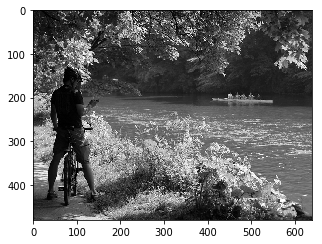

In [12]:
test = random.sample(test_images, 5)
test_image = f'{image_dir}/{test[1]}'
plt.figure(figsize=(5,5))
img = get_image(f'{test_image}')
print(f'greedy search : {greedy_decoder(img)}\n beam search k=3 : {beam_search(img, k=3)}\n beam search k=5 : {beam_search(img, k=5)}\n beam search k=7: {beam_search(img, k=7)}')
plt.imshow(img/255.)